## load packages

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

## load data

In [2]:
dar_markers=pickle.load(open('/data/leuven/351/vsc35107/lustre1_stt/data/sun/snap2_allfragments/08/Analysis_fisher_functional/data/DAR_markers_AD_dict.pkl', 'rb'))

In [3]:
dar_markers

{'AD':                              Log2FC  Adjusted_pval Contrast
 chr1:21261735-21262235     0.575802   1.597029e-84       AD
 chr18:48873288-48873788    0.565149   8.331974e-93       AD
 chr17:64990880-64991380    0.558544   2.481218e-95       AD
 chr5:157100285-157100785   0.551362   3.581266e-84       AD
 chr15:90845100-90845600    0.549813   3.855783e-97       AD
 ...                             ...            ...      ...
 chr12:100190040-100190540 -0.403347   1.131132e-52       AD
 chr7:4025628-4026128      -0.403512   1.500157e-53       AD
 chr3:192123035-192123535  -0.408950   1.281893e-57       AD
 chr17:82845249-82845749   -0.411765   5.417614e-56       AD
 chr10:5935616-5936116     -0.412102   8.793042e-58       AD
 
 [39420 rows x 3 columns],
 'nonAD':                              Log2FC  Adjusted_pval Contrast
 chr10:5935616-5936116      0.412102   8.793042e-58    nonAD
 chr17:82845249-82845749    0.411765   5.417614e-56    nonAD
 chr3:192123035-192123535   0.408950   1.

In [4]:
for k in dar_markers.keys():
    Log2FC=np.log2(1.5)
    Adjusted_pval=0.05
    d=dar_markers[k].loc[(dar_markers[k]['Log2FC']>Log2FC) & (dar_markers[k]['Adjusted_pval']<0.05), :]
    print(f"{k}: {d.shape}")

AD: (0, 3)
nonAD: (0, 3)


In [5]:
for k in dar_markers.keys():
    Log2FC=0.2
    Adjusted_pval=0.05
    d=dar_markers[k].loc[(dar_markers[k]['Log2FC']>Log2FC) & (dar_markers[k]['Adjusted_pval']<0.05), :]
    print(f"{k}: {d.shape}")

AD: (1139, 3)
nonAD: (451, 3)


In [6]:
concatenated_df = pd.concat(
    [df.assign(key=key) for key, df in dar_markers.items()],
    ignore_index=False
)
concatenated_df = concatenated_df.reset_index()
concatenated_df[['chr', 'start', 'end']] = concatenated_df['index'].str.split(':|-', expand=True)
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)

concatenated_df = concatenated_df.drop(columns=['index'])
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)
concatenated_df = concatenated_df[['chr', 'start', 'end'] + [col for col in concatenated_df.columns if col not in ['chr', 'start', 'end']]]
duckdb.register('peaks', concatenated_df)

## snps

In [7]:
parquet_file_path="/lustre1/project/stg_00079/students/tingting/data/GWAS/020results_expansion/Bellenguez_etal_Stage1_result.expanded.parquet"
snps=duckdb.read_parquet(parquet_file_path)

query=f"""
SELECT * from snps
"""
snps_df=duckdb.query(query).df()

snps_df['r_square'] = np.where(snps_df['r_square'] != '.', snps_df['p_value'], snps_df['r_square'])
duckdb.register('snps', snps_df)

query = f"""
SELECT Chromosome,
       start_pos,
       snp_pos,
       rsid,
       r_square AS stats
FROM snps

UNION ALL

SELECT Chromosome_AD AS Chromosome, 
       start_pos_AD AS start_pos, 
       snp_pos_AD AS snp_pos, 
       rsid_AD AS rsid, 
       p_value AS stats
FROM snps;
"""

snps_long = duckdb.query(query).df()

snps_long['stats'] = pd.to_numeric(snps_long['stats'], errors='coerce')
filtered_df = snps_long.dropna(subset=['stats'])
sum(filtered_df.duplicated())
duckdb.register('snps', filtered_df)

In [8]:
query=f"""
SELECT
    pk.chr,
    pk.start,
    pk.key,
    pk.Log2FC,
    pk.Adjusted_pval,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.stats
FROM
    snps s
JOIN
    peaks pk ON s.chromosome = pk.chr
                      AND s.start_pos BETWEEN pk.start AND pk.end;
"""
snps_peaks_joined_table=duckdb.query(query).df()

print(sum(snps_peaks_joined_table.duplicated()))
snps_peaks_joined_table=snps_peaks_joined_table.drop_duplicates()
print(snps_peaks_joined_table.shape)

10082
(49518, 9)


In [9]:
snps_peaks_joined_table['-log_pval'] = -np.log10(snps_peaks_joined_table['stats'] + 1e-10)  

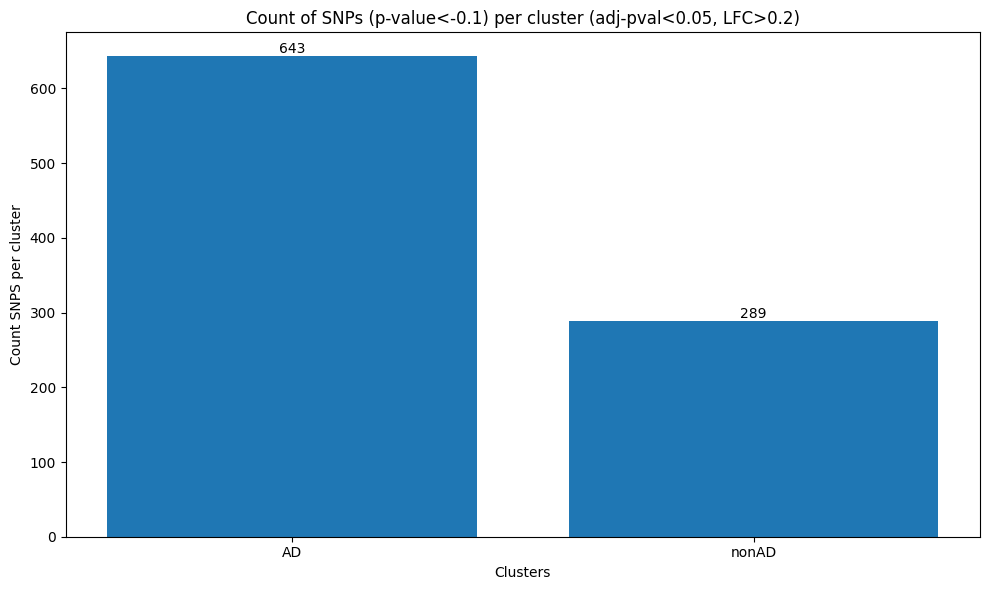

In [10]:
counts = snps_peaks_joined_table[(snps_peaks_joined_table['Log2FC'] > 0.2)&(snps_peaks_joined_table['Adjusted_pval'] <0.05)]['key'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
bars=plt.bar(counts.index, counts.values)

# Add labels, title, and custom tick labels
plt.xlabel('Clusters')
plt.ylabel('Count SNPS per cluster')
plt.title('Count of SNPs (p-value<-0.1) per cluster (adj-pval<0.05, LFC>0.2)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')
# Display the plot
plt.tight_layout()
plt.show()

## explore

In [68]:
df=snps_peaks_joined_table[(snps_peaks_joined_table['Log2FC'] > 0.2)&(snps_peaks_joined_table['Adjusted_pval'] <0.05)]

In [33]:
df.shape

(932, 10)

In [34]:
df.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,stats,-log_pval
17,chr4,86981726,AD,0.218777,4.066717e-103,86981902,86981903,rs3775185,0.01985,1.702239
30,chr18,484772,AD,0.237134,2.057544e-37,484816,484817,rs149429272,0.01949,1.710188
43,chr7,89247,AD,0.525895,1.881293e-79,89286,89287,.,0.01962,1.707301
44,chr7,89247,AD,0.525895,1.881293e-79,89286,89287,.,0.01957,1.708409
57,chr2,65377641,AD,0.317294,5.790855e-94,65377688,65377689,rs6546130,0.01944,1.711304


In [35]:
df=df[df['rsid'] != '.']
df.shape

(898, 10)

## DARs from clusters

In [14]:
dar_markers=pickle.load(open('/data/leuven/351/vsc35107/lustre1_stt/data/sun/snap2_allfragments/08/Analysis_fisher_functional/data/DAR_markers_dict.pkl', 'rb'))
concatenated_df = pd.concat(
    [df.assign(key=key) for key, df in dar_markers.items()],
    ignore_index=False
)
concatenated_df = concatenated_df.reset_index()
concatenated_df[['chr', 'start', 'end']] = concatenated_df['index'].str.split(':|-', expand=True)
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)

concatenated_df = concatenated_df.drop(columns=['index'])
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)
concatenated_df = concatenated_df[['chr', 'start', 'end'] + [col for col in concatenated_df.columns if col not in ['chr', 'start', 'end']]]
duckdb.register('peaks_clusters', concatenated_df)

In [15]:
query=f"""
SELECT
    pk.chr,
    pk.start,
    pk.key,
    pk.Log2FC,
    pk.Adjusted_pval,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.stats
FROM
    snps s
JOIN
    peaks_clusters pk ON s.chromosome = pk.chr
                      AND s.start_pos BETWEEN pk.start AND pk.end;
"""
snps_peaks_clusters=duckdb.query(query).df()

print(sum(snps_peaks_clusters.duplicated()))
snps_peaks_clusters=snps_peaks_clusters.drop_duplicates()
print(snps_peaks_clusters.shape)

45369
(222831, 9)


In [65]:
dff=snps_peaks_clusters[(snps_peaks_clusters['Log2FC'] > np.log2(1.5))&(snps_peaks_clusters['Adjusted_pval'] <0.05)]

In [40]:
dff.shape

(13831, 9)

In [18]:
dff.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,stats
0,chr7,12211869,4,0.258595,5.455035e-106,12212163,12212164,rs1019307,8.147000e-07
1,chr7,12211869,4,0.258595,5.455035e-106,12212044,12212045,rs1019309,7.004000e-07
147,chr7,12211869,4,0.258595,5.455035e-106,12211933,12211934,rs7781670,6.080000e-07
296,chr7,12211869,7,0.386462,1.809075e-146,12212163,12212164,rs1019307,8.147000e-07
297,chr7,12211869,7,0.386462,1.809075e-146,12212044,12212045,rs1019309,7.004000e-07


In [41]:
dff=dff[dff['rsid'] != '.']
dff.shape

(13623, 9)

## venn diagram

In [19]:
from matplotlib_venn import venn2, venn3

In [69]:
ad=df.loc[df['key']=='AD',:]['rsid'].tolist()
nonad=df.loc[df['key']=='nonAD',:]['rsid'].tolist()

In [70]:
list(set(ad) & set(nonad))

['.']

In [38]:
df.shape

(898, 10)

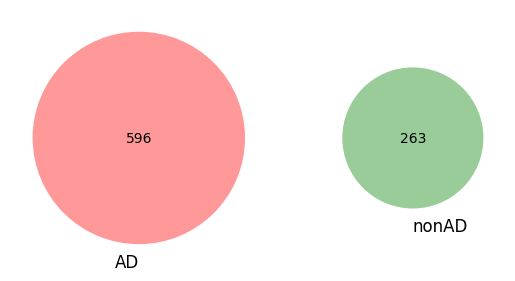

In [64]:
venn2([set(ad), set(nonad)], set_labels = ('AD', 'nonAD'))

In [22]:
cluster0=dff.loc[dff['key']=='0',:]['rsid'].tolist()

In [23]:
list(set(ad) & set(nonad) & set(cluster0))

['.']

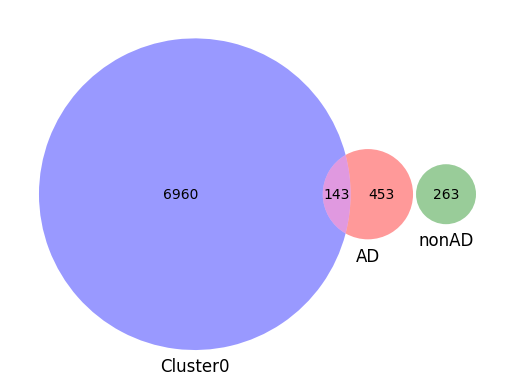

In [44]:
venn3([set(ad), set(nonad), set(cluster0)], set_labels = ('AD', 'nonAD', 'Cluster0'))

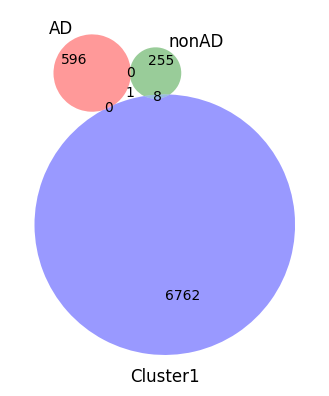

In [54]:
cluster1=dff.loc[dff['key']=='1',:]['rsid'].tolist()
venn3([set(ad), set(nonad), set(cluster1)], set_labels = ('AD', 'nonAD', 'Cluster1'))

In [46]:
def show_venn(cluster_num):
    cluster=dff.loc[dff['key']==cluster_num,:]['rsid'].tolist()
    venn3([set(ad), set(nonad), set(cluster)], set_labels = ('AD', 'nonAD', f'Cluster{cluster_num}'))

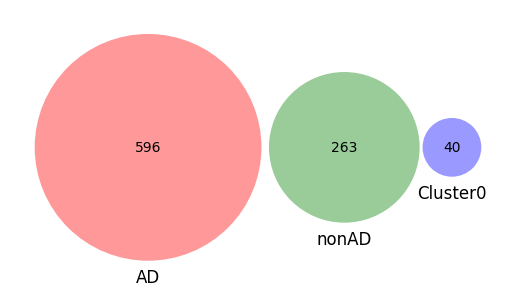

In [47]:
show_venn('0')

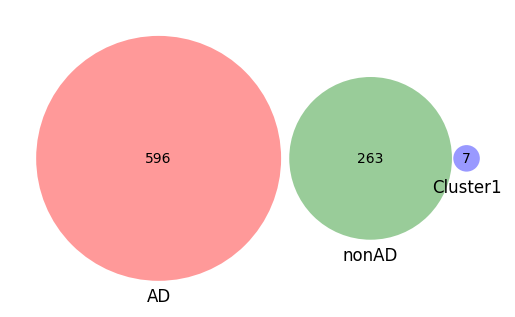

In [48]:
show_venn('1')

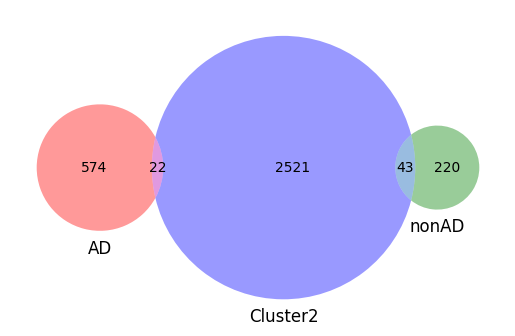

In [49]:
show_venn('2')

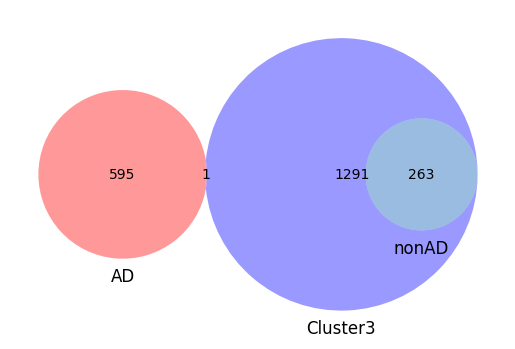

In [50]:
show_venn('3')

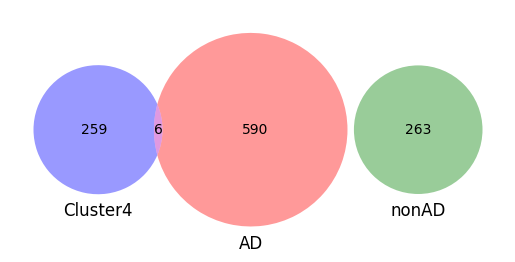

In [51]:
show_venn('4')

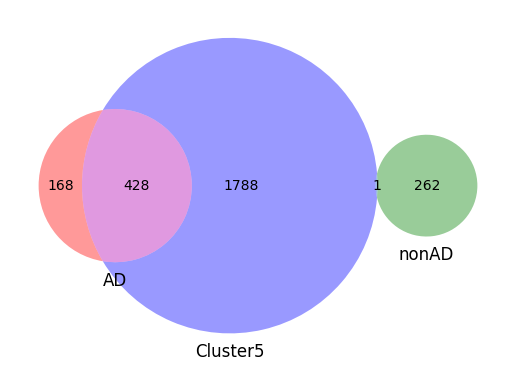

In [52]:
show_venn('5')

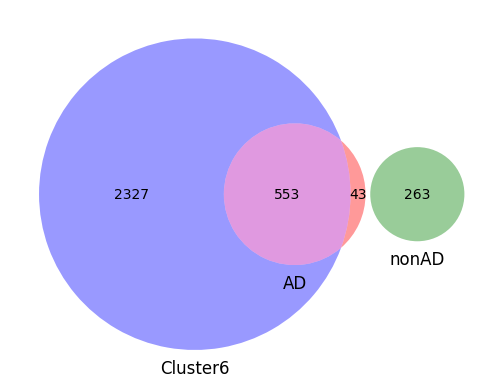

In [53]:
show_venn('6')

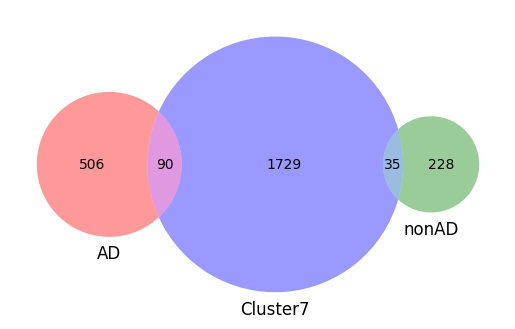

In [54]:
show_venn('7')

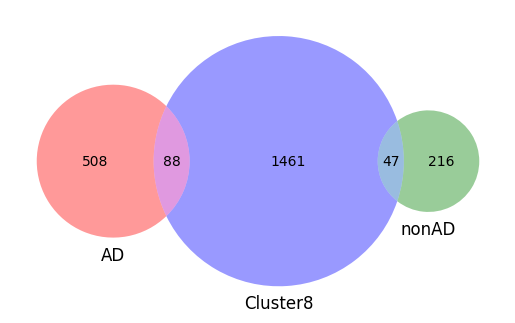

In [55]:
show_venn('8')

## correlation

In [56]:
all=pd.concat([df,dff])

In [57]:
all.key.unique()

array(['AD', 'nonAD', '8', '5', '4', '7', '3', '6', '2', '0', '1'],
      dtype=object)

In [28]:
all.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,stats,-log_pval
426,chr11,85947855,AD,0.210906,5.468555e-89,85947964,85947965,rs35866111,8.935000e-07,6.048857
427,chr11,85947855,AD,0.210906,5.468555e-89,85948217,85948218,rs34584483,8.854000e-07,6.052811
431,chr19,44685009,AD,0.278863,1.308567e-50,44685244,44685245,rs537892644,7.464000e-07,6.126970
432,chr2,202997129,AD,0.299019,2.744302e-67,202997230,202997231,rs145299755,5.708000e-07,6.243440
433,chr2,202997129,AD,0.299019,2.744302e-67,202997186,202997187,rs148707292,5.439000e-07,6.264401


In [58]:
unique_rsids = all['rsid'].unique()
unique_keys = all['key'].unique()
result_df = pd.DataFrame(0, index=unique_rsids, columns=unique_keys)
for key in unique_keys:
    key_rsids = all[all['key'] == key]['rsid']
    result_df.loc[key_rsids, key] = 1

In [59]:
result_df.shape

(9131, 11)

In [60]:
result_df.head()

,AD,nonAD,8,5,4,7,3,6,2,0,1
rs3775185,1,0,0,1,0,0,0,1,0,0,0
rs149429272,1,0,0,1,0,0,0,1,0,0,0
rs6546130,1,0,0,1,0,0,0,1,0,0,0
rs6546131,1,0,0,1,0,0,0,1,0,0,0
rs12713534,1,0,1,1,0,0,0,1,0,0,0


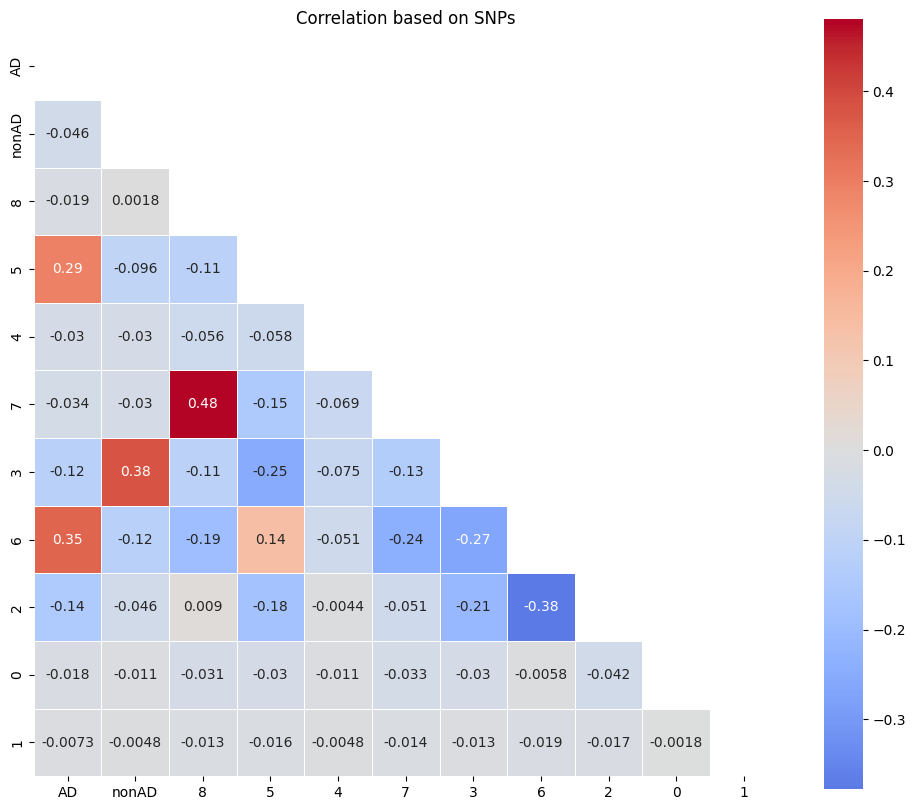

In [61]:
corr=result_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))

sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, square=True, linewidths=.5, center=0)
plt.title('Correlation based on SNPs')
# Show the plot
plt.show()

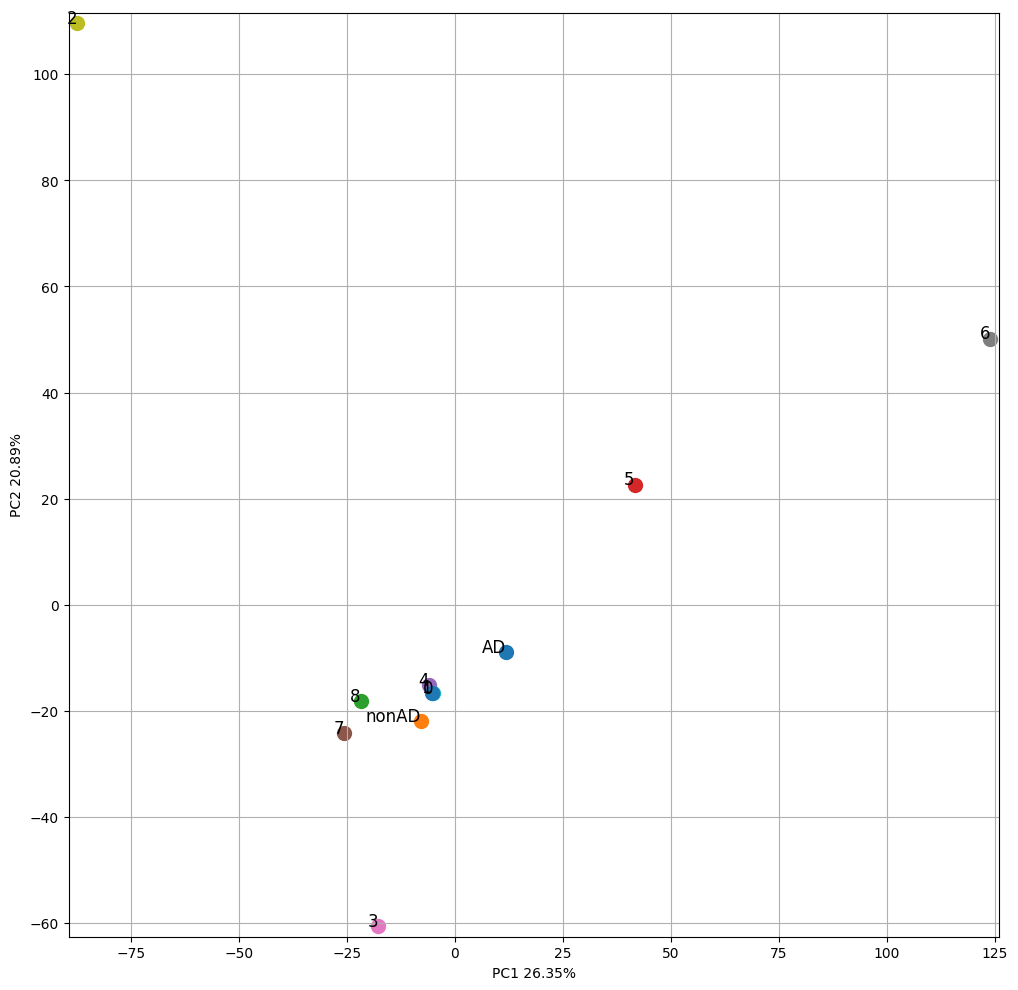

In [62]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(result_df.T)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
principal_df = pd.DataFrame(data=principal_components, index=result_df.columns, columns=['PC1', 'PC2'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot points and add text labels
for name, row in principal_df.iterrows():
    plt.scatter(row.PC1, row.PC2, marker='o', s=100)  # s=100 for larger points
    plt.text(row.PC1, row.PC2, name, fontsize=12, ha='right')

# Set limits
plt.xlim(principal_df.PC1.min() - 2, principal_df.PC1.max() + 2)
plt.ylim(principal_df.PC2.min() - 2, principal_df.PC2.max() + 2)

# Add explained variance ratio to labels
explained_variance_ratio = pca.explained_variance_ratio_
plt.xlabel(f'PC1 {100*explained_variance_ratio[0]:.2f}%')
plt.ylabel(f'PC2 {100*explained_variance_ratio[1]:.2f}%')

# Show the plot
plt.grid()
plt.show()